# Задание 1. Точечные фильтры. 

### 1) Метрика сходства двух изображений, реализуем алгоритм PSNR.

**Импортируем OpenCV и прочее**

In [1]:
import cv2
import statistics as st
import math
import time
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
print(cv2.__version__)

4.4.0


**Добавляем изображения** (Оригинальное и сжатое)

In [2]:
image_orig = cv2.imread("./PSNR-example-base.png") # Оригинальное
image_comp = cv2.imread("./PSNR-example-comp-90.jpg") # Сжатое

**Изображения:**

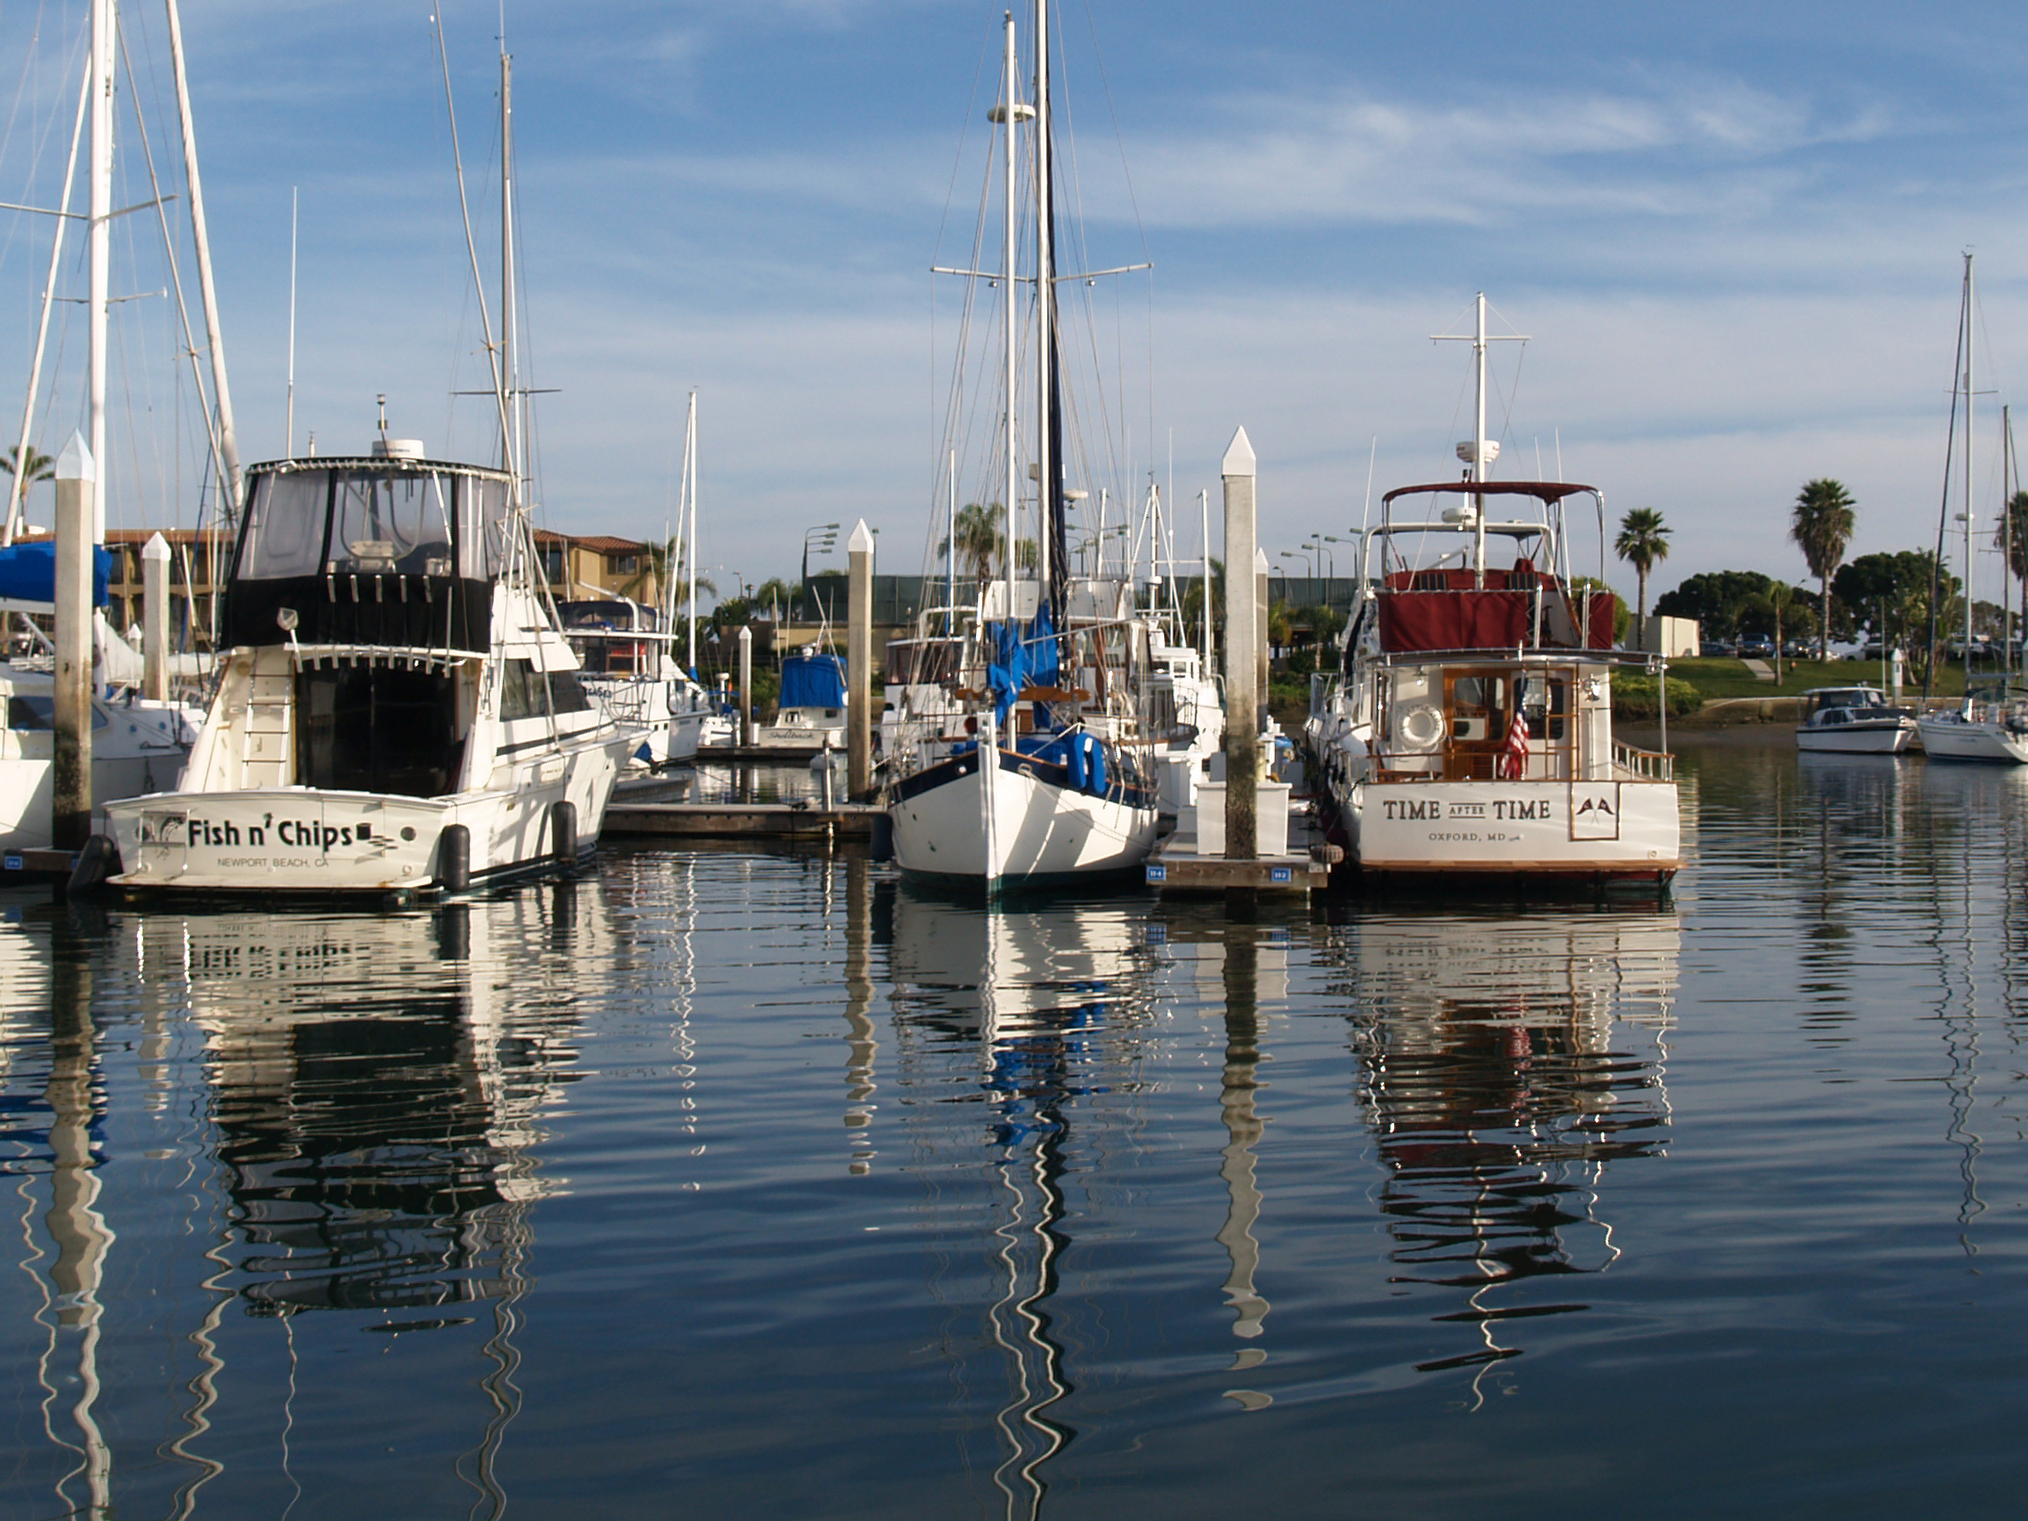

In [3]:
Image(data="./PSNR-example-base.png", width = 350)

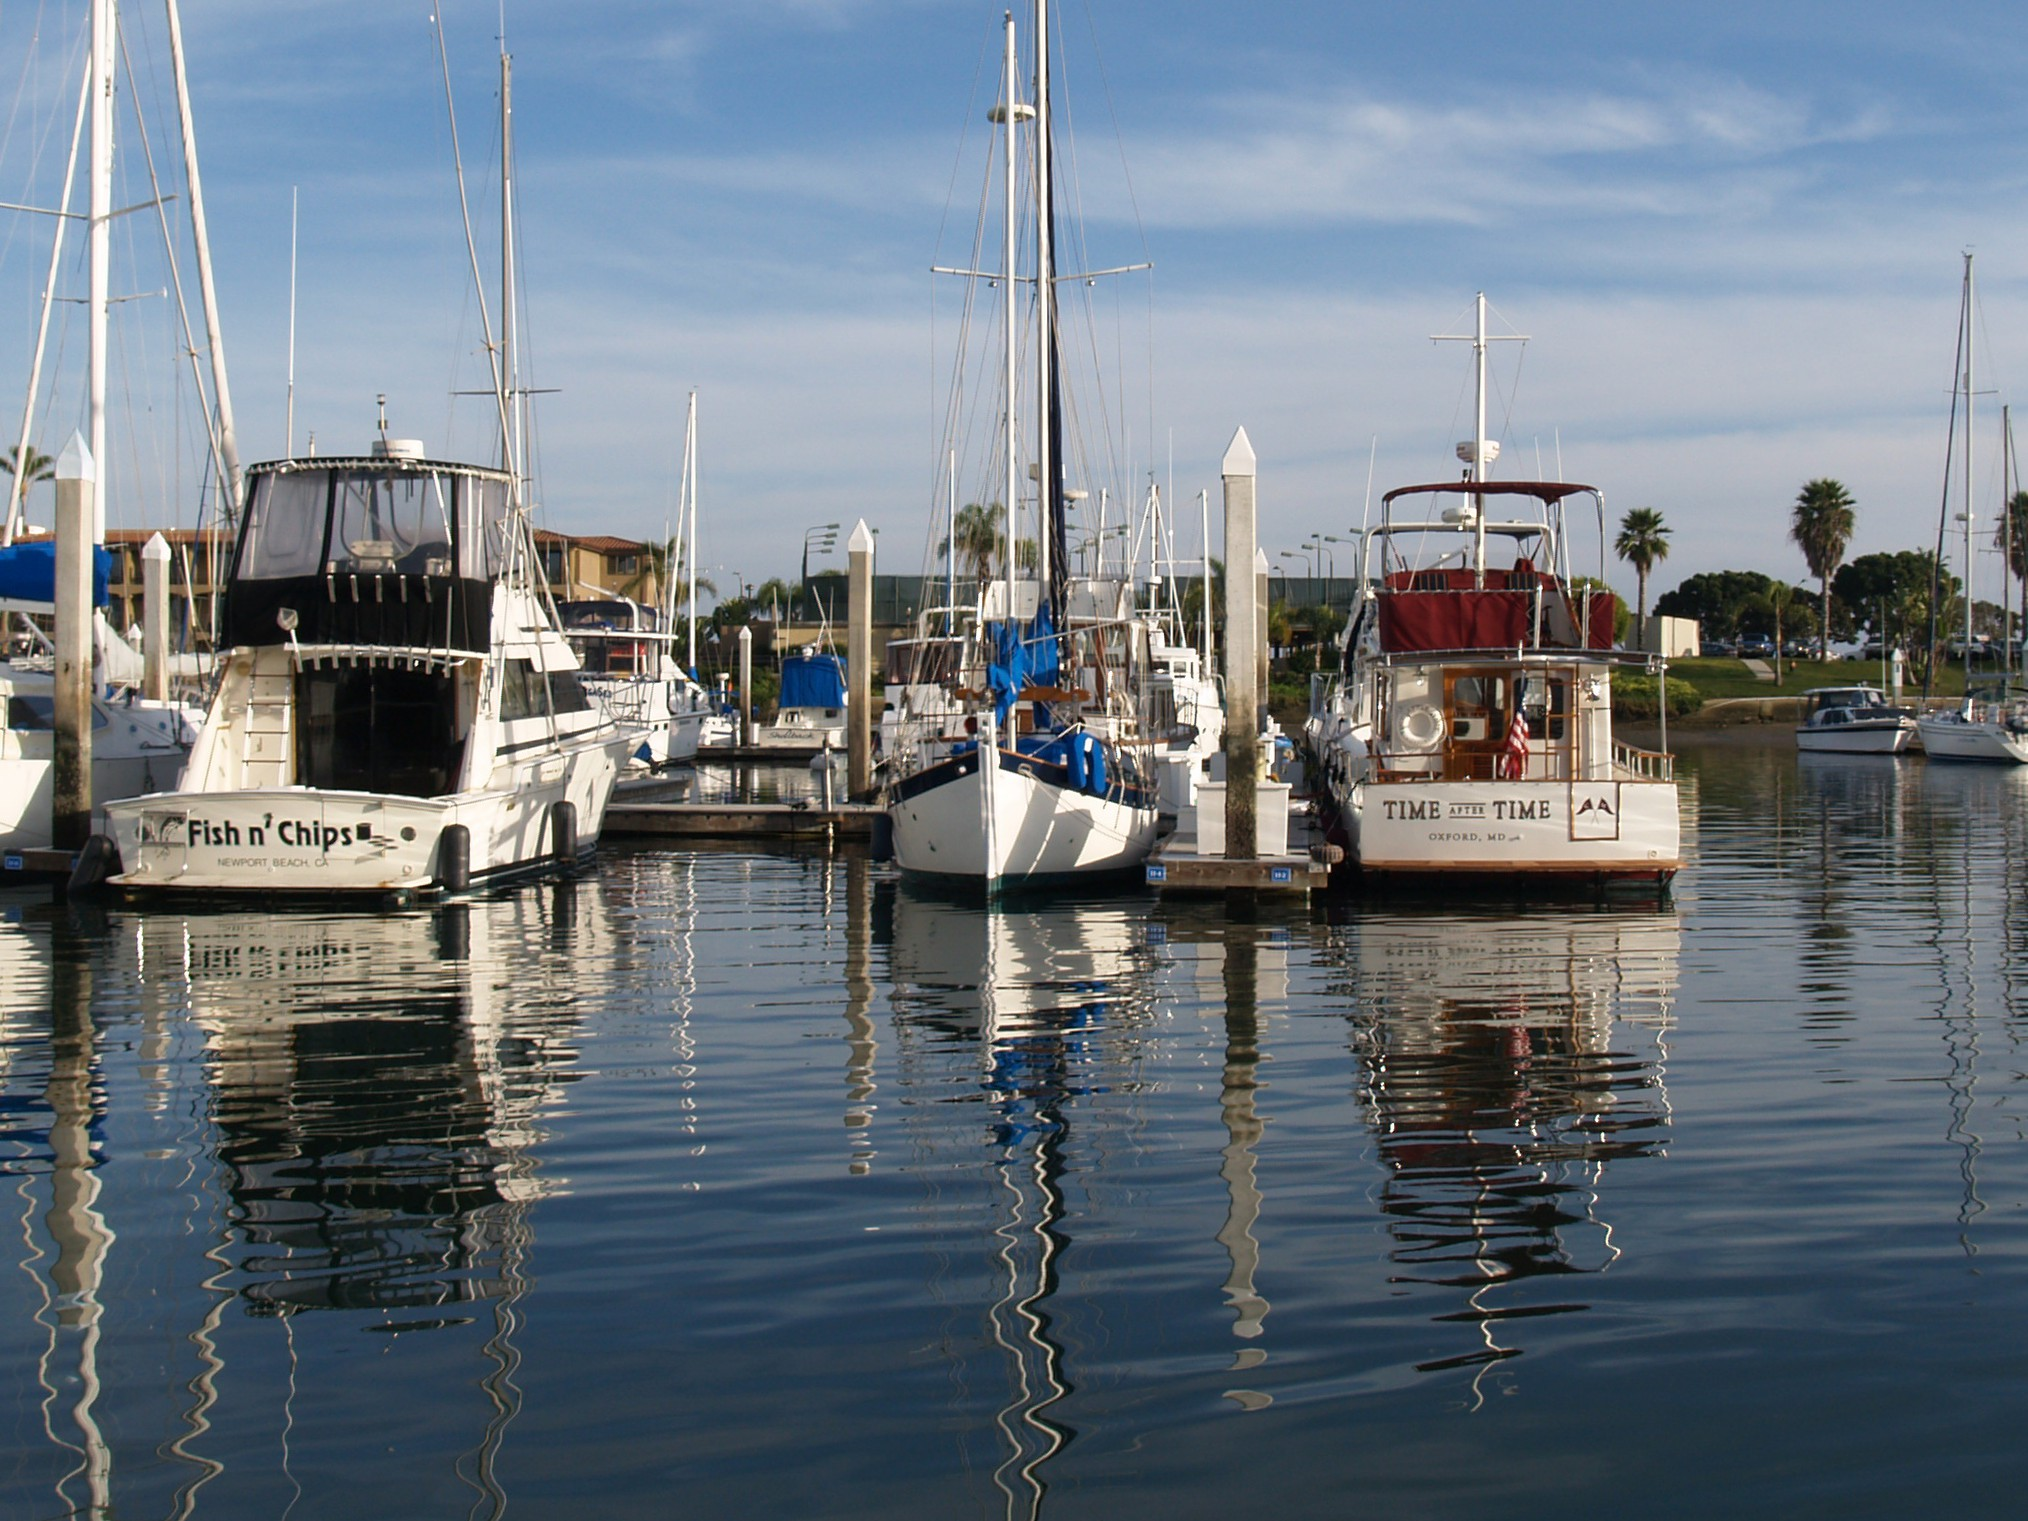

In [4]:
Image(data="./PSNR-example-comp-90.jpg", width = 350)

**Вычисляем PSNR**

In [5]:
def psnr(image_1, image_2):
    image_change = (image_1 - image_2) ** 2
    
    MSE_R = st.fmean([pixel[0] for row in image_change for pixel in row])
    MSE_G = st.fmean([pixel[1] for row in image_change for pixel in row])
    MSE_B = st.fmean([pixel[2] for row in image_change for pixel in row])

    MSE = (MSE_R + MSE_G + MSE_B) / 3

    MAX_I = 2 ** 8

    PSNR = 10 * math.log10(MAX_I ** 2 / MSE);
    return PSNR

**Искомая метрика:**

In [6]:
psnr(image_orig, image_comp)

39.27874355280623

### 2) Оттенки серого.

Считываем изображение

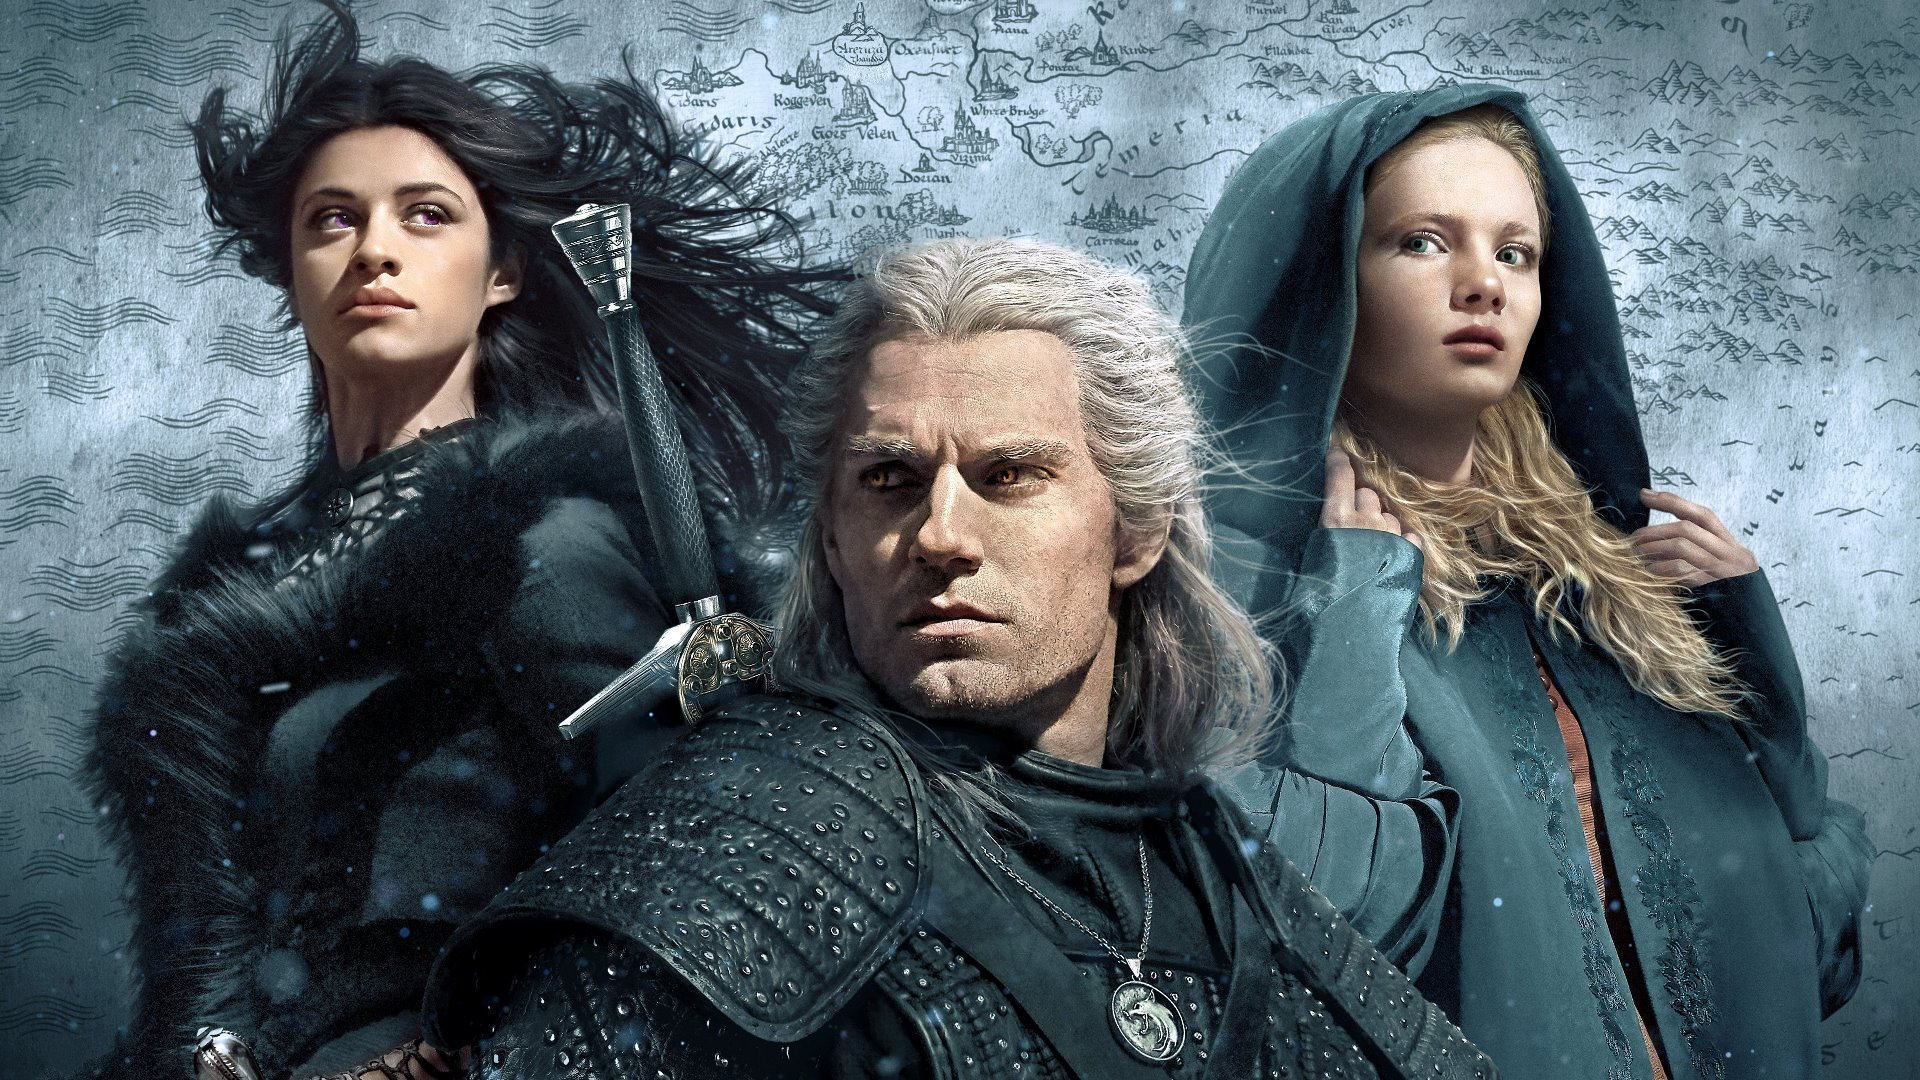

In [7]:
image = cv2.imread("hero-poster-full-hd.jpg")
Image(data="hero-poster-full-hd.jpg", width = 400)

Конвертируем в серый, использую cv2::cvtColor()

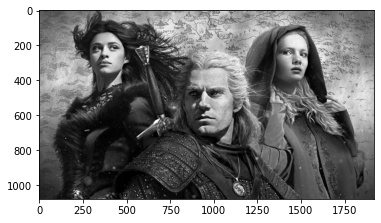

In [8]:
cv_start_time = time.time()
cv_gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv_end_time = time.time()
plt.imshow(cv_gray_image, cmap='gray', vmin = 0, vmax = 255)

Конвертируем в серый, используя average  (R + G + B) / 3 фильтр

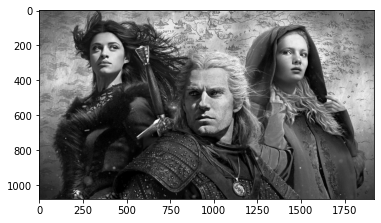

In [9]:
my_start_time = time.time()
for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
        pixel = image[i, j]
        average = (int(pixel[0]) + int(pixel[1]) + int(pixel[2])) // 3
        image[i, j] = average
my_end_time = time.time()
plt.imshow(image, cmap='gray', vmin = 0, vmax = 255)

Сравниваем полученные изображения, используя метрику psnr

In [10]:
image_change = cv_gray_image.copy()
for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
        image_change[i, j] = (int(image[i][j][0]) - int(image_change[i, j])) ** 2

MSE = st.fmean([pixel for row in image_change for pixel in row])

MAX_I = 2 ** 8

PSNR = 10 * math.log10(MAX_I ** 2 / MSE);
print(PSNR)

43.11458515041498


Время работы cv реализации

In [11]:
print(cv_end_time - cv_start_time)

0.00400233268737793


Время работы собственной реализации

In [12]:
print(my_end_time - my_start_time)

6.865523099899292


Выводы: собственная реализация по качеству и скорости работы сильно отстает от cv реализации

### 3) Конвертация м/у цветовыми моделями.

Загружаем изображение

In [13]:
image = cv2.imread("cat.JPG")

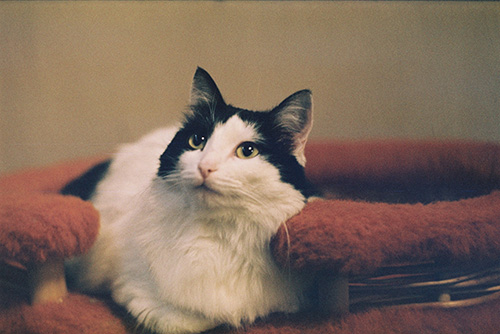

In [14]:
Image(data="./cat.JPG", width = 400)

#### Преобразование из BGR в YUV

In [15]:
image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

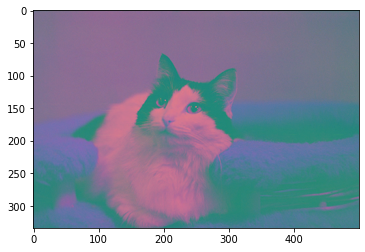

In [16]:
plt.imshow(image_yuv)

Теперь реализуем конвертацию. высчитываем компоненты

In [17]:
B, G, R = cv2.split(image)

Y = np.ndarray(shape=B.shape, dtype=B.dtype)
U = np.ndarray(shape=B.shape, dtype=B.dtype)
V = np.ndarray(shape=B.shape, dtype=B.dtype)

for i in range(0, image.shape[0]):
    for j in range(0, image.shape[1]):
        Y[i, j] = int(0.299 * R[i, j] + 0.587 * G[i, j] + 0.114 * B[i, j])
        U[i, j] = int(-0.147 * R[i, j] - 0.289 * G[i, j] + 0.437 * B[i, j] + 128)
        V[i, j] = int(0.615 * R[i, j] - 0.515 * G[i, j] - 0.09 * B[i, j] + 128)

Объединяем их в одно изображение

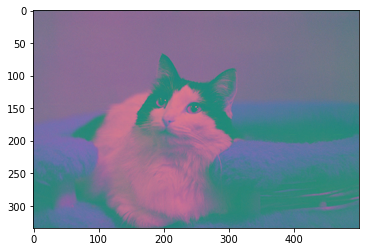

In [18]:
my_image_yuv = cv2.merge((Y, U, V))
plt.imshow(my_image_yuv)

Вычисляем меру сходства

In [19]:
psnr(image_yuv, my_image_yuv)

51.07281084690037

#### Преобразование из YUV в BGR

Конвертируем ищображение из YUV в RGB с помощью OpenCV

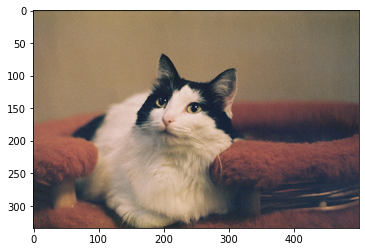

In [20]:
image_bgr = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
plt.imshow(image_bgr)

Теперь реализуем конвертацию. высчитываем компоненты

In [21]:
Y, U, V = cv2.split(my_image_yuv)
B = np.ndarray(shape=Y.shape, dtype=Y.dtype)
G = np.ndarray(shape=Y.shape, dtype=Y.dtype)
R = np.ndarray(shape=Y.shape, dtype=Y.dtype)
for i in range(0, my_image_yuv.shape[0]):
    for j in range(0, my_image_yuv.shape[1]):
        R[i, j] = int(Y[i, j] + 1.13983 * (V[i, j] - 128))
        G[i, j] = int(Y[i, j] - 0.39465 * (U[i, j] - 128) - 0.5806 * (V[i, j] - 128))
        B[i, j] = int(Y[i, j] + 2.03211 * (U[i, j] - 128))

Объединяем их в одно изображение

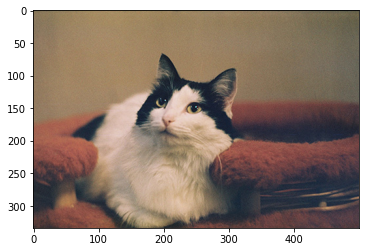

In [22]:
my_image_bgr = cv2.merge((R, G, B))
plt.imshow(my_image_bgr)

Вычисляем меру сходства

In [23]:
PSNR = psnr(image_bgr, my_image_bgr)
PSNR

44.05398478715847

#### Яроксть с замером времени

Функция увеличения яркости для BGR

In [24]:
def bright_bgr(source_image, value):
    B, G, R = cv2.split(source_image)
    for i in range(0, source_image.shape[0]):
        for j in range(0, source_image.shape[1]):
            B[i, j] += value
            if B[i, j] > 255: 
                B[i, j] = 255
            G[i, j] += value
            if G[i, j] > 255: 
                G[i, j] = 255
            R[i, j] += value
            if R[i, j] > 255: 
                R[i, j] = 255
    dest_image = cv2.merge((B, G, R))
    return dest_image

Функция увеличения яркости для YUV

In [25]:
def bright_yuv(source_image, value):
    Y, U, V = cv2.split(source_image)
    for i in range(0, source_image.shape[0]):
        for j in range(0, source_image.shape[1]):
            Y[i, j] += value
            if Y[i, j] > 255: 
                Y[i, j] = 255
    dest_image = cv2.merge((Y, U, V))
    return dest_image

3.4725420475006104


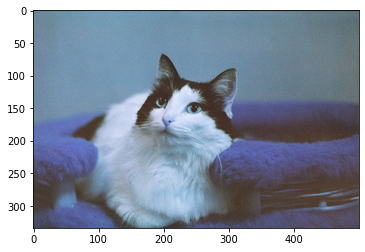

In [26]:
start_time = time.time()
plt.imshow(bright_bgr(image, 15))
end_time = time.time()
print(end_time - start_time)

1.2109994888305664


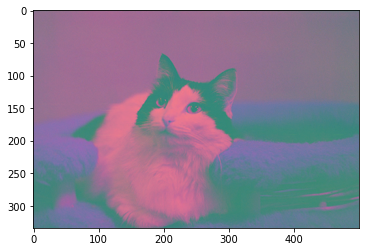

In [27]:
start_time = time.time()
plt.imshow(bright_yuv(image_yuv, 20))
end_time = time.time()
print(end_time - start_time)